In [38]:
# --- Data Handling ---
import pandas as pd               # for working with dataframes (reading CSV, cleaning, wrangling)

# --- Visualization ---
import matplotlib.pyplot as plt   # for plotting charts and graphs
import seaborn as sns             # for nicer statistical plots (optional)

# --- Machine Learning (Scikit-learn) ---
from sklearn.model_selection import train_test_split   # split data into train/test sets
from sklearn.linear_model import LinearRegression, Ridge  # regression models
from sklearn.impute import SimpleImputer              # handle missing values
from sklearn.pipeline import make_pipeline            # chain steps (encoding, imputation, model)
from sklearn.metrics import mean_absolute_error, r2_score  # model evaluation metrics

# --- Encoding (handle categorical features) ---
from category_encoders import OneHotEncoder   # one-hot encoding for boroughs

# --- Interactive Widgets ---
import ipywidgets as widgets      # create sliders, dropdowns, etc.
from ipywidgets import interact   # easily link widgets with functions

# --- Display Tools (Optional) ---
from IPython.display import VimeoVideo  # if you want to embed videos


### Wrangle Function Description
The `wrangle()` function cleans and prepares the Mexico City real estate dataset for analysis.  
1. It filters the data to include only **apartments under $100,000 USD** in **Distrito Federal**.  
2. It removes **extreme outliers** in surface area using the 10th–90th percentile range.  
3. It splits the **latitude and longitude** into separate numeric columns.  
4. It extracts the **borough name** from location strings.  
5. It drops columns with too many missing values or irrelevant information.  
6. It removes columns directly related to price to prevent **data leakage** in modeling.  


In [5]:
def wrangle(filepath):
    # Read the raw dataset
    data = pd.read_csv(filepath)

    # Keep only apartments under 100,000 USD in Distrito Federal
    is_apartment = data['property_type'] == 'apartment'
    is_cheap = data['price_aprox_usd'] < 100000
    is_in_city = data['place_with_parent_names'].str.contains('Distrito Federal')
    data = data[is_apartment & is_cheap & is_in_city]

    # Remove extreme outliers in surface area (keep only 10th–90th percentile)
    low, high = data['surface_covered_in_m2'].quantile([0.1, 0.9])
    mask_area = data['surface_covered_in_m2'].between(low, high)
    data = data[mask_area]

    # Split 'lat-lon' column into separate numeric 'lat' and 'lon' columns
    data[['lat', 'lon']] = data['lat-lon'].str.split(',', expand=True).astype(float)
    data = data.drop(columns='lat-lon')

    # Extract borough name (2nd item in place_with_parent_names)
    data['borough'] = data['place_with_parent_names'].str.split('|', expand=True)[1]
    data = data.drop(columns='place_with_parent_names')

    # Drop columns with more than 50% missing values
    many_missing = [col for col in data.columns if data[col].isna().sum() > len(data) // 2]
    data = data.drop(columns=many_missing)

    # Drop columns that aren’t useful for modeling
    drop_list = ["operation", "property_type", "currency", "properati_url"]
    data = data.drop(columns=drop_list)

    # Prevent data leakage (remove columns highly related to target price)
    price_related = ['price', 'price_aprox_local_currency', 'price_per_m2']
    data = data.drop(columns=price_related)

    return data


### Dataset Source
The dataset used in this project is sourced from [Kaggle: Mexico City Real Estate Dataset](https://www.kaggle.com/datasets/allankirwa/mexico-city-real-estate-dataset) by **Allan Kirwa**.  

It contains property listings with detailed attributes such as price, surface area, location, and other relevant features, making it suitable for real estate market analysis and predictive modeling.


In [15]:
df = wrangle("/content/mexico-city-real-estate-1.csv")
df.head()

,price_aprox_usd,surface_covered_in_m2,lat,lon,borough
11,94022.66,57.0,23.634501,-102.552788,Benito Juárez
20,70880.12,56.0,19.402413,-99.095391,Iztacalco
21,68228.99,80.0,19.357820,-99.149406,Benito Juárez
22,24235.78,60.0,19.504985,-99.208557,Azcapotzalco
26,94140.20,50.0,19.354219,-99.126244,Coyoacán


In [17]:
df.columns

Index(['price_aprox_usd', 'surface_covered_in_m2', 'lat', 'lon', 'borough'], dtype='object')

This code creates a histogram showing the **distribution of apartment prices** in USD. It sets up the figure and axes, plots the price data, and adds appropriate axis labels and a title for clear interpretation.


Text(0.5, 1.0, 'Distribution of Apartment Prices')

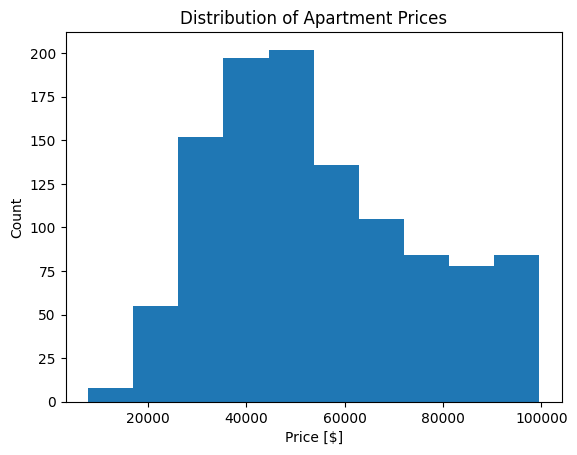

In [9]:
 # Create figure and axes
 fig, ax = plt.subplots()
 # Plot the histogram on the axes object
 ax.hist(df["price_aprox_usd"])
 # Label axes using the axes
 ax.set_xlabel("Price [$]")
 ax.set_ylabel("Count")
 # Add title
 ax.set_title("Distribution of Apartment Prices")

This code generates a **scatter plot** to visualize the relationship between an apartment’s **covered surface area (in square meters)** and its **price in USD**, with labeled axes and a descriptive title for clarity.


Text(0.5, 1.0, 'Mexico City: Price vs. Area')

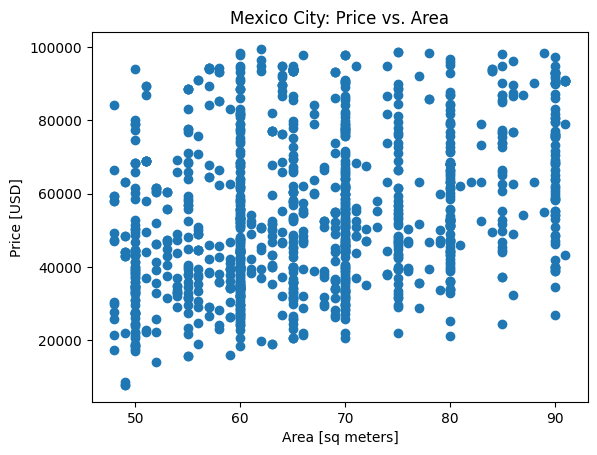

In [11]:
# Create figure and axes
fig, ax = plt.subplots()
# Create the scatter plot on the axes object
ax.scatter(df["surface_covered_in_m2"], df["price_aprox_usd"])
# Label axes
ax.set_xlabel("Area [sq meters]")
ax.set_ylabel("Price [USD]")
# Add title
ax.set_title("Mexico City: Price vs. Area")

This code uses **Plotly Express** to create an interactive **Mapbox scatter plot** of apartment listings in Mexico City.

1. It plots each property by its **latitude and longitude**.
2. Points are **colored by price**, allowing quick visual comparison across locations.
3. Hovering over a point shows the **price in USD**.
4. The map is centered on the dataset’s mean coordinates with a zoom level of 10.
5. An **OpenStreetMap style** is applied for a clear, user-friendly background.


In [13]:
import plotly.express as px
# Plot Mapbox location and price
fig = px.scatter_mapbox(
df,
lat="lat",
# Latitude column
lon="lon",
# Longitude column
color="price_aprox_usd",  # Color points by price
width=800,
height=600,
hover_data=["price_aprox_usd"],  # Show price on hover
zoom=10,
center={"lat": df["lat"].mean(), "lon": df["lon"].mean()}  # Center map
)
# Use OpenStreetMap style
fig.update_layout(mapbox_style="open-street-map")
# Show the plot
fig.show()

This code applies a **Linear Regression model** to predict apartment prices based on surface area:

1. It selects **surface area** as the feature (`X`) and **price** as the target (`y`).
2. The dataset is split into **training (80%)** and **testing (20%)** sets.
3. A **Linear Regression model** is trained on the training data and then used to make predictions on the test data.
4. Model performance is evaluated using **Mean Absolute Error (MAE)** and the **R² score**.
5. Finally, a plot is created showing **actual prices (scatter)** vs. **predicted prices (regression line)** for visual comparison.


Mean Absolute Error: 16879.73694527725
R² Score: 0.08884123975115954


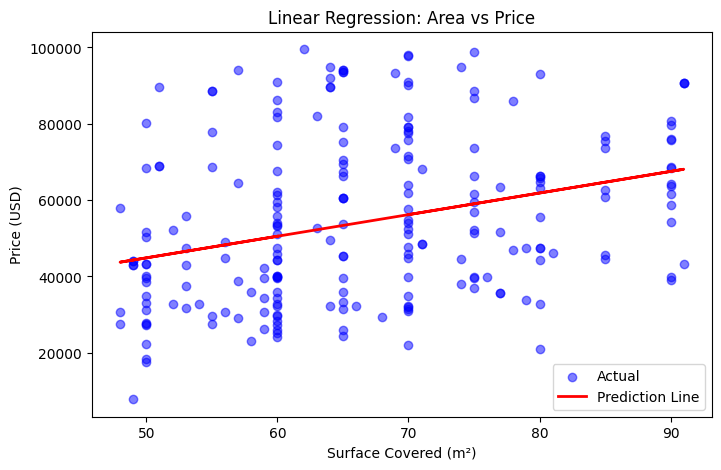

In [20]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# Feature (X) = surface area, Target (y) = price
X = df[['surface_covered_in_m2']]
y = df['price_aprox_usd']

# Split data: 80% train, 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the Linear Regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions on test data
y_pred = model.predict(X_test)

# Evaluate model performance
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("Mean Absolute Error:", mae)
print("R² Score:", r2)

# Plot actual vs predicted
plt.figure(figsize=(8,5))
plt.scatter(X_test, y_test, color='blue', alpha=0.5, label="Actual")
plt.plot(X_test, y_pred, color='red', linewidth=2, label="Prediction Line")
plt.xlabel("Surface Covered (m²)")
plt.ylabel("Price (USD)")
plt.title("Linear Regression: Area vs Price")
plt.legend()
plt.show()


Here’s how to interpret them:

MAE ≈ 16,880 USD → On average, the predictions are off by about $17k.

R² ≈ 0.09 → The model explains only 9% of the variation in prices. That’s very low, meaning area alone is a weak predictor of house prices.

This makes sense: price depends not only on area but also on location (lat/lon, borough), neighborhood, amenities, etc.

# Now considering the remaining columns like location and neighborhood

In [26]:
# Target (house price)
y = df["price_aprox_usd"]

# Features (everything except target)
X = df.drop(columns=["price_aprox_usd"])

# Split data into train (80%) and test (20%)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Training shape:", X_train.shape)
print("Testing shape:", X_test.shape)

Training shape: (880, 4)
Testing shape: (221, 4)


In [27]:
# Build pipeline:
# 1. Encode categorical variables
# 2. Handle missing values
# 3. Ridge Regression model
model = make_pipeline(
    OneHotEncoder(use_cat_names=True),
    SimpleImputer(),
    Ridge()
)

# Train the model
model.fit(X_train, y_train)

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['borough'], use_cat_names=True)),
                ('simpleimputer', SimpleImputer()), ('ridge', Ridge())])

# Use your model to generate a Series of predictions for X_test

In [29]:
from sklearn.metrics import mean_absolute_error, r2_score

# Predict on test set
y_test_pred = pd.Series(model.predict(X_test), index=X_test.index)

# Evaluate performance
mae = mean_absolute_error(y_test, y_test_pred)
r2 = r2_score(y_test, y_test_pred)

print("Mean Absolute Error:", mae)
print("R² Score:", r2)

# Show first few predictions
print("\nSample Predictions:")
print(y_test_pred)


Mean Absolute Error: 15712.621701521428
R² Score: 0.17428767972662684

Sample Predictions:
1335    67246.012802
2797    51817.232791
1696    46936.189470
2941    54932.541932
1018    58326.856079
            ...     
4089    66796.455631
3827    32292.710814
4566    51867.432712
4175    60657.524516
2080    49329.660862
Length: 221, dtype: float64


Basically, you need to create a Series called `feat_imp` that shows how much each feature contributes to your Ridge model’s predictions. The feature names will be the index (so you know which column each value belongs to), and the corresponding values will be the model’s coefficients. Since some coefficients can be positive and others negative, you should sort them by their absolute value, so the least important features (close to zero influence) appear at the top and the most important ones (strong effect on price, either up or down) appear at the bottom.


In [30]:
import pandas as pd

# Intercept (optional)
intercept = model.named_steps["ridge"].intercept_

# Retrieve coefficients
coefficients = model.named_steps["ridge"].coef_

# Retrieve feature names from OneHotEncoder (if using a pipeline)
features = model.named_steps["onehotencoder"].get_feature_names_out()  # use get_feature_names_out() in newer versions

# Create a Series of names and values
feat_imp = pd.Series(coefficients, index=features)

# Sort by absolute value ascending
feat_imp = feat_imp.reindex(feat_imp.abs().sort_values().index)

feat_imp


,0
surface_covered_in_m2,345.829925
borough_Cuauhtémoc,-483.423916
borough_Miguel Hidalgo,1537.108371
borough_Iztacalco,3206.454118
borough_Coyoacán,3484.798652
borough_Gustavo A. Madero,-3883.261537
borough_Azcapotzalco,4871.091603
borough_Álvaro Obregón,4954.898879
borough_Venustiano Carranza,-5182.775767
lat,-6954.319296


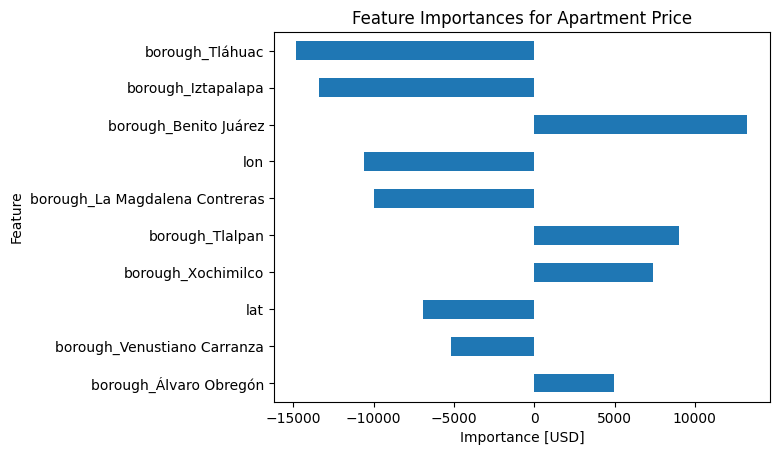

In [31]:
# Create figure and axes
fig, ax = plt.subplots()

# Plot the horizontal bar chart of the top 10 coefficients by absolute value
feat_imp.sort_values(key=abs, ascending=False).head(10).plot(kind='barh', ax=ax)

# Label axes
ax.set_xlabel("Importance [USD]")
ax.set_ylabel("Feature")

# Add title
ax.set_title("Feature Importances for Apartment Price")

# Invert y-axis so the most influential feature is on top
ax.invert_yaxis()


## Step 1: Setup the Input Widgets

Here we create interactive controls:
- A **slider** for entering the house area (in square meters).
- A **dropdown menu** for choosing the borough (neighborhood).

In [33]:
import ipywidgets as widgets
from ipywidgets import interact

# Dropdown for borough selection
borough_dropdown = widgets.Dropdown(
    options=[
        "Álvaro Obregón", "Azcapotzalco", "Benito Juárez", "Coyoacán",
        "Cuauhtémoc", "Gustavo A. Madero", "Iztacalco", "Iztapalapa",
        "La Magdalena Contreras", "Miguel Hidalgo", "Tláhuac",
        "Tlalpan", "Venustiano Carranza", "Xochimilco"
    ],
    description='Borough:',
    value="Cuauhtémoc"  # default option
)

# Slider for surface area (m²)
area_slider = widgets.IntSlider(
    value=100, min=20, max=500, step=5,
    description='Area (m²):'
)


## Step 2: Define the Prediction Function

This function:
1. Takes the **user’s input** (area + borough).  
2. Fills in average latitude and longitude (so user doesn’t need to input them).  
3. Uses the trained Ridge model to predict the house price.  
4. Prints the estimated price in USD.


In [36]:
def predict_price(area, borough):
    # Create a DataFrame with input values
    input_data = pd.DataFrame({
        "surface_covered_in_m2": [area],
        "lat": [df["lat"].mean()],   # using dataset average latitude
        "lon": [df["lon"].mean()],   # using dataset average longitude
        "borough": [borough]
    })

    # Make prediction with trained model
    price_pred = model.predict(input_data)[0]
    print(f" Estimated Price: ${price_pred:,.0f} USD")


## Step 3: Run the Interactive Tool

Use the slider and dropdown to give inputs,  
and the model will instantly estimate the house price.


In [37]:
# Connect function with widgets
interact(predict_price, area=area_slider, borough=borough_dropdown);


interactive(children=(IntSlider(value=100, description='Area (m²):', max=500, min=20, step=5), Dropdown(descri…